In [92]:
from pathlib import Path
from functools import partial

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
from matplotlib.legend_handler import HandlerBase



from boplay.acq_funs.mes_utils import sample_yn1_ymax
from boplay.kernels import se_kernel
from boplay.gp import GaussianProcess

from boplay.kde import fit_kde

import seaborn as sns

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{bm}')

In [93]:
np.random.seed(0)
import boplay

# the parent of the module
SAVE_DIR = Path(boplay.__file__).parent.parent / "paper_plots"
print(f"Pics will be saved to: {SAVE_DIR}")

Pics will be saved to: /lambda/nfs/nethome-us-west-1/lukehg/mes/paper_plots


# Generate Data to Plot

In [ ]:

# idx_train = np.array([0, 50, 90, 100])
# idx_ytrain = np.array([0.5, 0.0, -0.2, 0.7])

# idx_train = np.array([0, 5, 65, 95, 100])
# idx_ytrain = np.array([-0.1, 0, -0.9, -0.4, -0.44])

# idx_train = np.array([5, 65, 95])
# idx_ytrain = np.array([0, -0.9, -0.4])

# idx_train = np.array([0, 65, 100])
# idx_ytrain = np.array([-0.1, -0.9, -0.44])

# idx_train = np.array([0, 16, 60, 83, 100])
# idx_ytrain = np.array([-0.1, 0, -0.9, -0.4, -0.44])

# x_idx = 35


idx_train = np.array([0, 17, 43, 84, 100])
idx_ytrain = np.array([-0.7, 0.8, -1.3, 0.3, -0.44])

x_idx = 65


# Generate data to plot
n_yn1 = 51
n_ymax = 50

y_n1_idx = np.array([45, 38, 1])
# y_n1_idx = np.array([50, 44, 20])
# y_n1_idx = np.array([n_yn1 - 1, (n_yn1 + 1) // 2, 0])

# make a grid of x-values
x_grid = np.linspace(0, 100, 101).reshape(-1, 1)
n_x = x_grid.shape[0]

# make a train set of x-values and y-values
x_train = x_grid[idx_train, :]
y_train = idx_ytrain.reshape(-1, 1)
y_best = float(max(y_train))

# make a kernel
kernel = partial(se_kernel, len_scale=10.0, sigma_f=1.0)

# make a Gaussian process

NOISE = 0.3 # normally 1e-9

gp = GaussianProcess(x_train=x_train, y_train=y_train, kernel=kernel, y_noise_std=NOISE)

# get the mean and covariance of the Gaussian process
y_mean, y_cov = gp.predict(x_test=x_grid)

# np.random.seed(0)
y_n1_samples, y_func_samples, y_max_samples, _ = sample_yn1_ymax(
    y_mean=y_mean,
    y_cov=y_cov,
    n_yn1=n_yn1,
    n_ymax=n_ymax,
    y_noise_std=NOISE,
)

# cherry pick 3 sampled y_n1 values
# y_n1_idx = np.array([n_yn1 - 1, (n_yn1 + 1) // 2, 0])


y_n1_samples = y_n1_samples[x_idx, y_n1_idx]  # (3,)
y_func_samples = y_func_samples[x_idx, y_n1_idx, :, :]  # (3, n_ymax, n_x)
y_max_samples = y_max_samples[x_idx, y_n1_idx, :]  # (3, n_ymax)
n_yn1 = 3


/tmp/ipykernel_676501/146470277.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_best = float(max(y_train))


# Function to plot a GP and Samples Fucntions

In [95]:
def plot_gp_and_sample_funcs(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_grid: np.ndarray,
    y_mean: np.ndarray,
    y_sd: np.ndarray,
    y_sampled_funcs: np.ndarray,
    ax: plt.Axes,
    y_min: float = -4,
    y_max: float = 6,
    y_max_marker: dict = {},
) -> None:
    """
    Plot the GP and the acquisition function on the given axes.
    """
    assert x_train.shape[0] == y_train.shape[0]
    assert x_grid.shape[0] == y_mean.shape[0]
    assert y_sampled_funcs.shape[1] == y_mean.shape[0]

    x_train = x_train.reshape(-1)
    x_grid = x_grid.reshape(-1)
    y_train = y_train.reshape(-1)
    y_mean = y_mean.reshape(-1)
    y_sd = y_sd.reshape(-1)

    # Line 1/2: plot the GP and the training data
    ax.fill_between(x_grid, y_mean - 2*y_sd, y_mean + 2*y_sd, alpha=0.2)
    ax.plot(x_grid, y_mean, label='GP mean', color='k')
    ax.plot(x_train, y_train, 'o', label='Training data', zorder=10, color="k")
    ax.set_ylim(y_min, y_max)

    f_label = "f(x) samples"
    y_max_label = "y_max samples"

    for i in range(y_sampled_funcs.shape[0]):
        y_sampled_func = y_sampled_funcs[i, :]
        ax.plot(x_grid, y_sampled_func, alpha=0.1, color="red", label=f_label)
        idx_max = np.argmax(y_sampled_func)
        ax.plot(x_grid[idx_max], y_sampled_func[idx_max], label=y_max_label, zorder=9, **y_max_marker)
        f_label = None
        y_max_label = None

# Plot the GP mean + error and sampled funtcions with their peaks

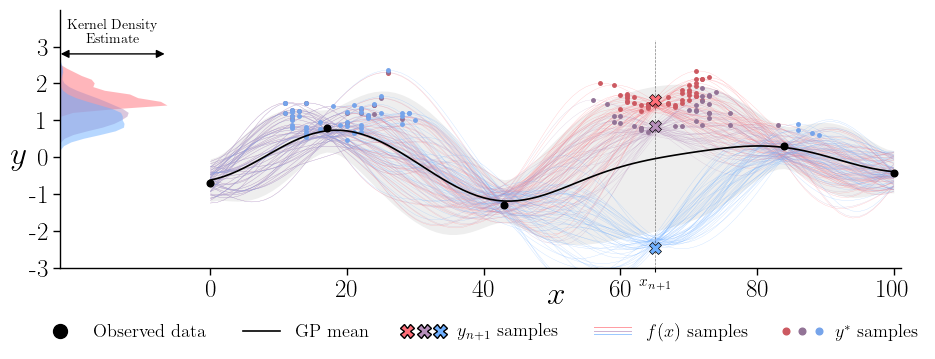

In [101]:
import seaborn as sns

COLORS = ["#FF6F79", "#B790BC", "#6FB0FF"]
Y_MAX_COLORS = ["#CC5961", "#927396", "#76A4EA"]


def plot_training_data(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_grid: np.ndarray,
    y_mean: np.ndarray,
    y_sd: np.ndarray,
    ax: plt.Axes,
    y_min: float = -3,
    y_max: float = 3.2,
) -> None:
    x_train = x_train.reshape(-1)
    x_grid = x_grid.reshape(-1)
    y_train = y_train.reshape(-1)
    y_mean = y_mean.reshape(-1)
    y_sd = y_sd.reshape(-1)
    ax.fill_between(x_grid, y_mean - 2*y_sd, y_mean + 2*y_sd, alpha=1, color="#EEEEEE", linewidth=0, zorder=-2)
    ax.plot(x_grid, y_mean, label='GP mean', color='k', zorder=10)
    ax.plot(x_train, y_train, 'o', label='Observed data', zorder=11, color="k")
    ax.set_ylim(y_min, y_max)


def plot_sample_functions(
    color: str,
    ymax_color: str,
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_grid: np.ndarray,
    y_mean: np.ndarray,
    y_sd: np.ndarray,
    y_sampled_funcs: np.ndarray,
    ax: plt.Axes,
) -> None:
    x_train = x_train.reshape(-1)
    x_grid = x_grid.reshape(-1)
    y_train = y_train.reshape(-1)
    y_mean = y_mean.reshape(-1)
    y_sd = y_sd.reshape(-1)

    f_label = "f(x) samples"
    y_max_label = "y_max samples"

    for i in range(y_sampled_funcs.shape[0]):
        y_sampled_func = y_sampled_funcs[i, :]
        ax.plot(x_grid, y_sampled_func, alpha=0.5, color=color, label=f_label, linewidth=0.2, zorder=-1)
        idx_max = np.argmax(y_sampled_func)
        ax.plot(
            x_grid[idx_max], 
            y_sampled_func[idx_max], 
            label=y_max_label, 
            zorder=9, 
            marker=".",
            markersize=5,
            markerfacecolor=ymax_color,
            color=ymax_color,
            # markeredgecolor="k",
            # markeredgewidth=0.3,
        )
        f_label = None
        y_max_label = None



fig, ax = plt.subplots(
    ncols=1, 
    figsize=(10, 4),
    sharey=True,
)


y_sd = np.sqrt(np.diag(y_cov))




plot_training_data(
    x_train=x_train,
    y_train=y_train,
    x_grid=x_grid,
    y_mean=y_mean,
    y_sd=y_sd,
    ax=ax,
    y_min=-2.5,
    y_max=4,
)

max_heights = []
for i, (y_sampled_funcs, color) in enumerate(zip(y_func_samples, COLORS)):
    plot_sample_functions(
        color=color,
        ymax_color=Y_MAX_COLORS[i],
        x_train=x_train,
        y_train=y_train,
        x_grid=x_grid,
        y_mean=y_mean,
        y_sd=y_sd,
        y_sampled_funcs=y_sampled_funcs,
        ax=ax,
    )

    ax.plot(
        x_grid[x_idx], 
        y_n1_samples[i], 
        label="y_n1 sample", 
        zorder=10, 
        marker="X",
        markersize=8,
        markerfacecolor=color,
        markeredgecolor="k",
        markeredgewidth=0.5,
        linewidth=0,
    )

    kde_bws = [0.08, 0.15, 0.15]
    y_max_samples_i = y_max_samples[i, :]
    kde = fit_kde(y_max_samples_i, bw=kde_bws[i])
    y_grid = np.linspace(-4, 6, 101)

    KDE_X_LIM = -22
    KDX_X_SCALE = 9

    ax.fill_betweenx(y_grid, [KDE_X_LIM] * len(y_grid), KDX_X_SCALE * kde.density(y_grid) + KDE_X_LIM, alpha=0.5, color=color, linewidth=0)


    max_heights += [max(KDX_X_SCALE * kde.density(y_grid) + KDE_X_LIM)]

Y_LIM = (-3, 4)
ax.set_ylim(*Y_LIM)
ax.set_xlim(KDE_X_LIM, 101)


ax.set_xticks(range(0, 101, 20))  
ax.set_xticklabels(range(0, 101, 20), fontsize=18)  
ax.set_yticks(range(-3, 4))  
ax.set_yticklabels(range(-3, 4), fontsize=18) 


x_label_pos = (50 - KDE_X_LIM) / (100 - KDE_X_LIM)
ax.set_xlabel(r"$x$", fontsize=24)
ax.set_ylabel(r"$y$", fontsize=24, rotation=0)
# ax.set_ylabel(r"$f(x)$", fontsize=24)
ax.xaxis.set_label_coords(x_label_pos, -0.05)
ax.yaxis.set_label_coords(-0.05, 3/8)
# ax.yaxis.set_label_coords(-0.02, 0.5)

# posAx, posBx = -22.3, max(max_heights)
# arrow = FancyArrowPatch(
#     posA=(posAx, 3.5), posB=(posBx, 3.5), 
#     arrowstyle='<|-|>', 
#     mutation_scale=12,  # size of arrowheads
#     linewidth=1,
#     color='black'
# )
# ax.add_patch(arrow)

# # Add text above the arrow
# ax.text((posAx + posBx) / 2, 3.7, "Kernel Density Estimate", ha='center', va='bottom', fontsize=10)


posAx, posBx = -22.3, max(max_heights)
arrow = FancyArrowPatch(
    posA=(posAx, 2.8), posB=(posBx, 2.8), 
    arrowstyle='<|-|>', 
    mutation_scale=12,  # size of arrowheads
    linewidth=1,
    color='black'
)
ax.add_patch(arrow)

ax.text((posAx + posBx) / 2, 3.4, "Kernel Density", ha='center', va='bottom', fontsize=10)
ax.text((posAx + posBx) / 2, 3, "Estimate", ha='center', va='bottom', fontsize=10)





class HandlerVerticalLines(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        lines = []
        n = len(orig_handle)
        spacing = height / (n + 1)
        for i, line in enumerate(orig_handle):
            l = mlines.Line2D([0, width],
                              [height - (i+1) * spacing] * 2,
                              color=line.get_color(),
                              linewidth=line.get_linewidth(),
                              alpha=line.get_alpha(),
                              linestyle=line.get_linestyle(),
                              transform=trans)
            lines.append(l)
        return lines

class HandlerHorizontalMarkers(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):

        spacing_factor = 1.8
        artists = []
        n = len(orig_handle)
        base_spacing = width / (n + 1)
        spacing = base_spacing * spacing_factor
        total_width = spacing * (n - 1)
        start_x = (width - total_width) / 2
        for i, m in enumerate(orig_handle):
            x = start_x + i * spacing
            artist = mlines.Line2D([x],
                                   [height / 2],
                                   marker=m.get_marker(),
                                   markersize=m.get_markersize(),
                                   markerfacecolor=m.get_markerfacecolor(),
                                   markeredgecolor=m.get_markeredgecolor(),
                                   linestyle='None',
                                   transform=trans)
            artists.append(artist)
        return artists


class VerticalGroup(tuple): pass
class HorizontalGroup(tuple): pass

multiple_line_handles = VerticalGroup((
    mlines.Line2D([], [], color=COLORS[0], linewidth=0.7, alpha=0.7),
    mlines.Line2D([], [], color=COLORS[1], linewidth=0.7, alpha=0.7),
    mlines.Line2D([], [], color=COLORS[2], linewidth=0.7, alpha=0.7)
))

multiple_ymax_marker_handles = HorizontalGroup((
    mlines.Line2D([], [], marker="o", color=Y_MAX_COLORS[0], linewidth=0),#, markeredgewidth=0.1, markeredgecolor="k"),
    mlines.Line2D([], [], marker="o", color=Y_MAX_COLORS[1], linewidth=0),#, markeredgewidth=0.1, markeredgecolor="k"),
    mlines.Line2D([], [], marker="o", color=Y_MAX_COLORS[2], linewidth=0),#, markeredgewidth=0.1, markeredgecolor="k")
))

multiple_yn1_marker_handles = HorizontalGroup((
    mlines.Line2D([], [], marker="X", markersize=10, color=COLORS[0], linewidth=0, linestyle=None, markeredgewidth=0, markeredgecolor="k"),
    mlines.Line2D([], [], marker="X", markersize=10, color=COLORS[1], linewidth=0, linestyle=None, markeredgewidth=0, markeredgecolor="k"),
    mlines.Line2D([], [], marker="X", markersize=10, color=COLORS[2], linewidth=0, linestyle=None, markeredgewidth=0, markeredgecolor="k")
))


ax.plot(
    [x_idx, x_idx],
    [-5, 3.18],
    color="k",
    linestyle="--",
    linewidth=0.5,
    alpha=0.5,
    zorder=3,
)
ax.minorticks_on()
ax.set_xticks([x_idx], minor=True)
ax.set_yticks([], minor=True)
ax.set_xticklabels([r"$x_{n+1}$"], minor=True)
minor_labels = ax.get_xticklabels(minor=True)
minor_labels[0].set_fontsize(11) 




handles = [
    mlines.Line2D([], [], color='k', marker="o", linewidth=0, markersize=10),
    mlines.Line2D([0], [1], color='k', linewidth=1.2), 
    multiple_yn1_marker_handles,
    multiple_line_handles,
    multiple_ymax_marker_handles,
]
labels = [
    "Observed data", 
    "GP mean", 
    r"$y_{n + 1}$ samples", 
    r"$f(x)$ samples", 
    r"$y^*$ samples",
]

plt.legend(
    handles, 
    labels, 
    handler_map={
        VerticalGroup: HandlerVerticalLines(),
        HorizontalGroup: HandlerHorizontalMarkers(),
    },
    ncols=5,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.35),
    frameon=False,
)


sns.despine(ax=ax)
plt.tight_layout()
plt.savefig(SAVE_DIR / "gp_samples_v3-noisy.pdf")